In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import multivariate_normal as mvn

import vsem_jax as vsem
from vsem_inv_prob import InvProb, VSEMPrior, VSEMLikelihood

import sys
sys.path.append("./../linear_Gaussian/")
from Gaussian import Gaussian

rng = np.random.default_rng(6435)


# Exact Inverse Problem

In [5]:
n_days = 365 * 2
par_names = ["kext", "av"]

# For exact MCMC
proposal_cov = np.diag([0.3**2, 0.04**2])

likelihood = VSEMLikelihood(rng, n_days, par_names)
prior = VSEMPrior(likelihood.par_names, rng)
inv_prob = InvProb(rng, prior, likelihood,proposal_cov=proposal_cov)

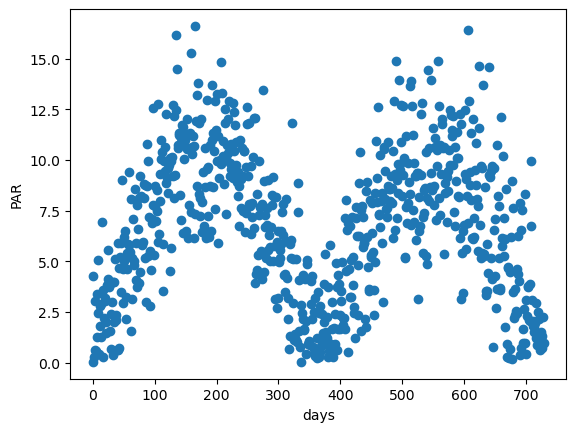

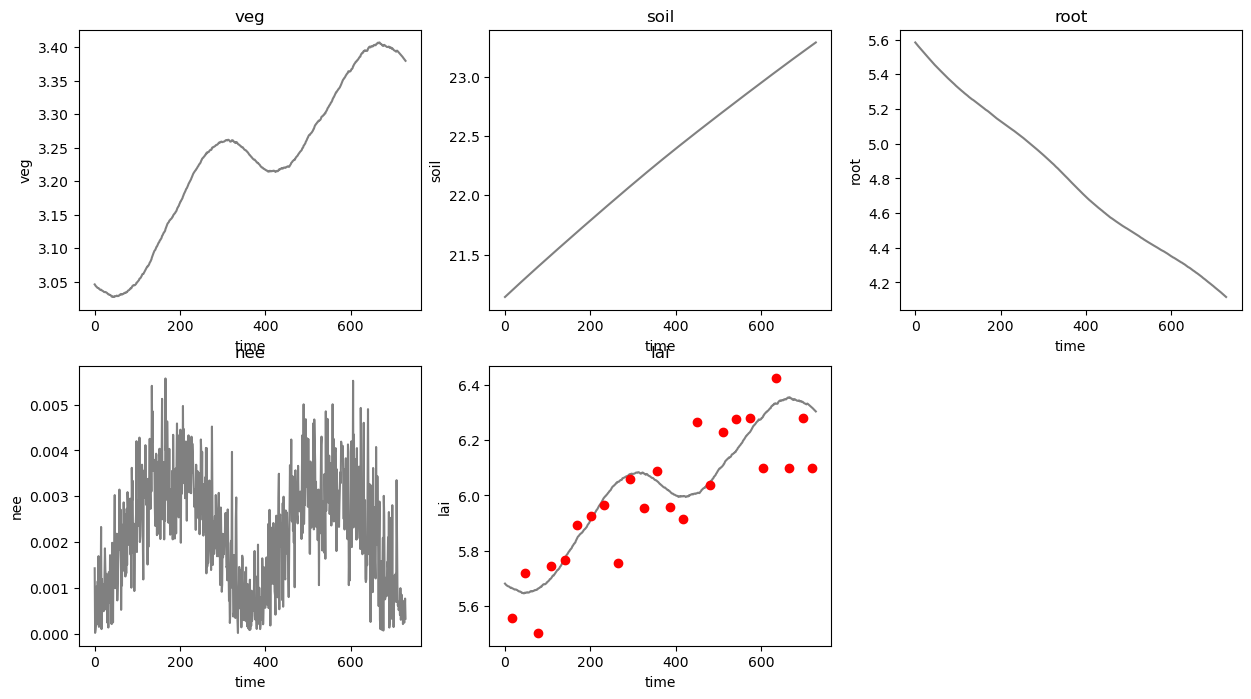

In [3]:
likelihood.plot_driver()
likelihood.plot_ground_truth()

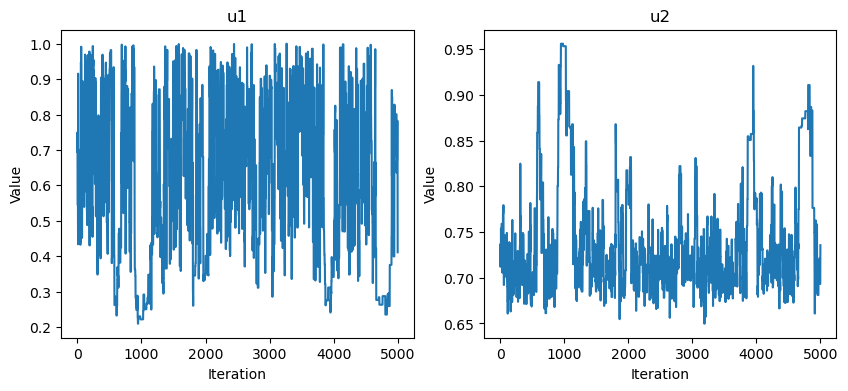

In [6]:
inv_prob.reset_sampler()
samp, trace_plot = inv_prob.sample_posterior(n_step=10000)

display(trace_plot)

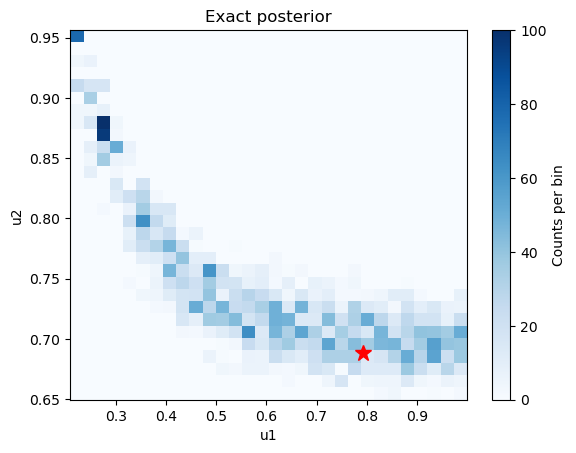

In [7]:
plt.hist2d(samp[:,0], samp[:,1], bins=30, cmap='Blues')
plt.plot(*likelihood.par_true, "*", color="red", markersize=12)
plt.colorbar(label='Counts per bin')
plt.xlabel('u1')
plt.ylabel('u2')
plt.title('Exact posterior')
plt.show()

In [112]:
log_post_grid.shape

(10000,)

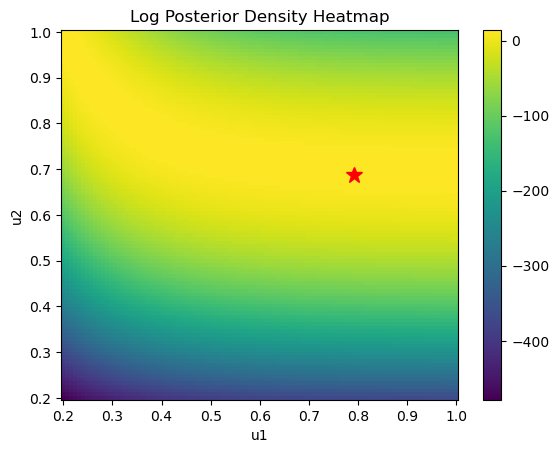

In [113]:
n_grid_1d = 100
u1_supp = prior.dists[par_names[0]].support()
u2_supp = prior.dists[par_names[1]].support()
u1_grid = np.linspace(u1_supp[0], u1_supp[1], n_grid_1d)
u2_grid = np.linspace(u2_supp[0], u2_supp[1], n_grid_1d)

U1_grid, U2_grid = np.meshgrid(u1_grid, u2_grid, indexing='xy')
U = np.stack([U1_grid.ravel(), U2_grid.ravel()], axis=1)
log_post = inv_prob.log_posterior_density(U)
log_post_grid = log_post_grid.reshape(U1_grid.shape)

plt.pcolormesh(U1_grid, U2_grid, log_post_grid, shading='auto', cmap='viridis')
plt.plot(*likelihood.par_true, "*", color="red", markersize=12)
plt.title("Log Posterior Density Heatmap")
plt.xlabel("u1")
plt.ylabel("u2")
plt.colorbar()
plt.show()

# GP Surrogate Model

In [54]:
# Initial design for emulator
# Enable Float64 for more stable matrix inversions.
from jax import config
import jax.numpy as jnp
import jax.random as jr
import gpjax as gpx
from flax import nnx
import matplotlib as mpl
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)
key = jr.key(123)

In [101]:
n = 20
x_design = jnp.asarray(prior.sample(n))
y_design = jnp.asarray(inv_prob.log_posterior_density(x_design)).reshape((-1,1))

design = gpx.Dataset(X=x_design, y=y_design)

In [102]:
# Prior Kernel
lengthscales = jnp.array([0.2, 0.2])
scale_squared = gpx.parameters.PositiveReal(design.y.var())
kernel = gpx.kernels.RBF(lengthscale=lengthscales, variance=scale_squared, 
                         n_dims=2)

In [103]:
# Mean Function
constant_param = gpx.parameters.Real(value=design.y.mean())
meanf = gpx.mean_functions.Constant(constant_param)

In [104]:
# Prior GP
gp_prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

In [105]:
# GP posterior
obs_stddev = gpx.parameters.PositiveReal(gp_prior.jitter)
gp_likelihood = gpx.likelihoods.Gaussian(num_datapoints=design.n, obs_stddev=obs_stddev)
gp_posterior = gp_prior * gp_likelihood
gp_posterior

ConjugatePosterior( # NonNegativeReal: 1 (8 B), PositiveReal: 3 (24 B), Real: 1 (8 B), Total: 5 (40 B)
  prior=Prior( # PositiveReal: 3 (24 B), Real: 1 (8 B), Total: 4 (32 B)
    kernel=RBF( # PositiveReal: 3 (24 B)
      active_dims=slice(None, None, None),
      n_dims=2,
      compute_engine=<gpjax.kernels.computations.dense.DenseKernelComputation object at 0x157a7f360>,
      lengthscale=PositiveReal( # 2 (16 B)
        value=Array(shape=(2,), dtype=dtype('float64')),
        tag="'positive'"
      ),
      variance=PositiveReal( # 1 (8 B)
        value=Array(13454.55411865, dtype=float64),
        tag="'positive'"
      )
    ),
    mean_function=Constant( # Real: 1 (8 B)
      constant=Real( # 1 (8 B)
        value=Array(-86.41863766, dtype=float64),
        tag="'real'"
      )
    ),
    jitter=1e-06
  ),
  likelihood=Gaussian( # NonNegativeReal: 1 (8 B)
    obs_stddev=NonNegativeReal( # 1 (8 B)
      value=Array(1.e-06, dtype=float64, weak_type=True),
      tag="'non_negative'

In [108]:
# Optimize hyperparameters

print("Starting mll: ", -gpx.objectives.conjugate_mll(gp_posterior, design))

gp_opt_posterior, history = gpx.fit_scipy(
    model=gp_posterior,
    objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d),
    train_data=design,
    trainable=gpx.parameters.Parameter,
)

print("Ending mll: ", -gpx.objectives.conjugate_mll(gp_opt_posterior, design))
print("History")
print(history)

Starting mll:  103.59910501033455
Optimization terminated successfully.
         Current function value: 84.836981
         Iterations: 82
         Function evaluations: 90
         Gradient evaluations: 90
Ending mll:  84.83698051119416
History
[103.59910501  96.45624784  95.02285815  94.96059307  94.95768961
  94.9561081   94.94246925  94.91827317  94.87469413  94.79606364
  94.65159915  93.96877674  93.70937865  93.34330278  92.95532969
  92.73765449  92.68062803  92.67748005  92.67571364  92.67549693
  92.67548427  92.67548392  92.67548336  92.67548236  92.6754805
  92.67547704  92.67547059  92.67545868  92.67543711  92.67539913
  92.67533421  92.6752252   92.67503999  92.67471591  92.67413488
  92.67308027  92.67116164  92.66768968  92.66147723  92.65052768
  92.6315182   92.59883139  92.5426838   92.44591888  92.27935656
  91.99629554  91.52904665  90.79748172  89.99101267  89.19891396
  88.32336512  87.39449163  87.19906226  87.08703035  87.03311967
  86.93143953  86.74517468  8

In [109]:
# GP predictions
U = jnp.asarray(U)

latent_dist = gp_opt_posterior.predict(U, train_data=design)
predictive_dist = gp_opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean
predictive_std = jnp.sqrt(predictive_dist.variance)

/var/folders/8y/dh1rsmhx3y13wxw2h2f713qm0000gn/T/ipykernel_7218/1622592862.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


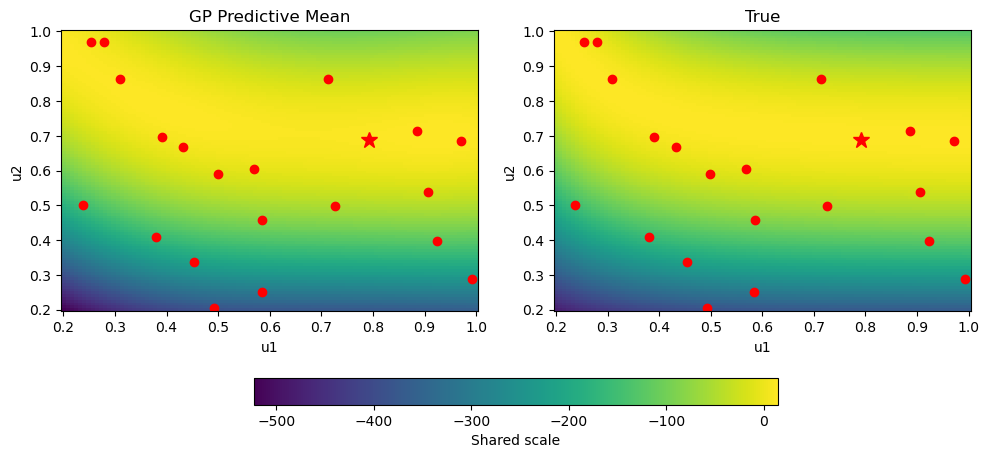

In [ ]:
# Compute shared color limits
vmin = min(np.min(predictive_mean), np.min(log_post_grid))
vmax = max(np.max(predictive_mean), np.max(log_post_grid))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Wider and taller

axs = np.array(axs).reshape(-1)

# Plot 1: GP Predictive Mean
m1 = axs[0].pcolormesh(
    U1_grid,
    U2_grid,
    predictive_std.reshape(U1_grid.shape),
    shading='auto',
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
)
axs[0].plot(*likelihood.par_true, "*", color="red", markersize=12)
axs[0].plot(design.X[:,0], design.X[:,1], "o", color="red")
axs[0].set_title("GP Predictive Mean")
axs[0].set_xlabel("u1")
axs[0].set_ylabel("u2")

# Plot 2: Log Posterior
m2 = axs[1].pcolormesh(
    U1_grid,
    U2_grid,
    log_post_grid,
    shading='auto',
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
)
axs[1].plot(*likelihood.par_true, "*", color="red", markersize=12)
axs[1].plot(design.X[:,0], design.X[:,1], "o", color="red")
axs[1].set_title("True")
axs[1].set_xlabel("u1")
axs[1].set_ylabel("u2")

fig.tight_layout()  # tighten up layout first

# Give some extra space below for the colorbar
fig.subplots_adjust(bottom=0.18)

# Add horizontal colorbar beneath the plots
cbar = fig.colorbar(
    m1, ax=axs, orientation='horizontal',
    fraction=0.07, pad=0.18
)
cbar.set_label('Shared scale')

fig.show()

/var/folders/8y/dh1rsmhx3y13wxw2h2f713qm0000gn/T/ipykernel_7218/532488991.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


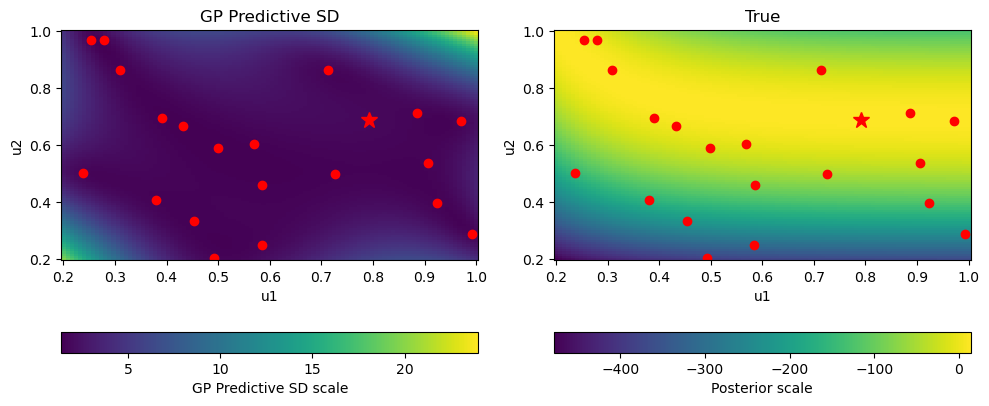

In [126]:
vmin = min(np.min(predictive_std), np.min(log_post_grid))
vmax = max(np.max(predictive_std), np.max(log_post_grid))


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs = np.array(axs).reshape(-1)

# --- First plot ---
m1 = axs[0].pcolormesh(
    U1_grid, U2_grid,
    predictive_std.reshape(U1_grid.shape),
    shading='auto', cmap='viridis'
)
axs[0].plot(*likelihood.par_true, "*", color="red", markersize=12)
axs[0].plot(design.X[:,0], design.X[:,1], "o", color="red")
axs[0].set_title("GP Predictive SD")
axs[0].set_xlabel("u1")
axs[0].set_ylabel("u2")

# --- Second plot ---
m2 = axs[1].pcolormesh(
    U1_grid, U2_grid,
    log_post_grid,
    shading='auto', cmap='viridis'
)
axs[1].plot(*likelihood.par_true, "*", color="red", markersize=12)
axs[1].plot(design.X[:,0], design.X[:,1], "o", color="red")
axs[1].set_title("True")
axs[1].set_xlabel("u1")
axs[1].set_ylabel("u2")

fig.tight_layout()
fig.subplots_adjust(bottom=0.28)  # extra space for both colorbars

# Plot colorbars beneath each plot, horizontally
cbar1 = fig.colorbar(
    m1, ax=axs[0], orientation='horizontal',
    fraction=0.07, pad=0.22
)
cbar1.set_label('GP Predictive SD scale')

cbar2 = fig.colorbar(
    m2, ax=axs[1], orientation='horizontal',
    fraction=0.07, pad=0.22
)
cbar2.set_label('Posterior scale')

fig.show()